## Cimetidine tutorial: indexing, spacegroup determination & structure solution
In this notebook, you can:
* Load the powder diffraction data and create the PowderPattern object
* Find the diffraction peaks and index them (determine the unit cell)
* Perform a profile fit to optimise the background and reflection profiles
* Determine the spacegroup
* Add a molecule to describe the contents of the Crystal structure
* Solve the Crystal structure using a Monte-Carlo/Parallel tempering algorithm
* Save the best result to a CIF file and to Fox .xmlgz format

Notes:
* This is an *ideal* case for structure solution from powder diffraction - a clean powder diffraction data easily indexed, an unambiguous spacegroup, and a relatively simple structure.
* It is important to follow the steps relatively linearly and avoid going back to previous cells until you know better. For example to avoid adding multiple times Scatterer/Molecule objects in the crystal structure, or multiple crystalline phases to the powder pattern with the same crystal, etc...

### Imports

In [1]:
# 'notebook' allows live update. Otherwise 'widget', 'ipympl', 'inline' can be used
%matplotlib notebook

import os
import pyobjcryst
import numpy as np
import matplotlib.pyplot as plt
from pyobjcryst.crystal import *
from pyobjcryst.powderpattern import *
from pyobjcryst.indexing import *
from pyobjcryst.molecule import *
from pyobjcryst.globaloptim import MonteCarlo
from pyobjcryst.io import xml_cryst_file_save_global

### Create powder pattern object, download data if necessary

<IPython.core.display.Javascript object>


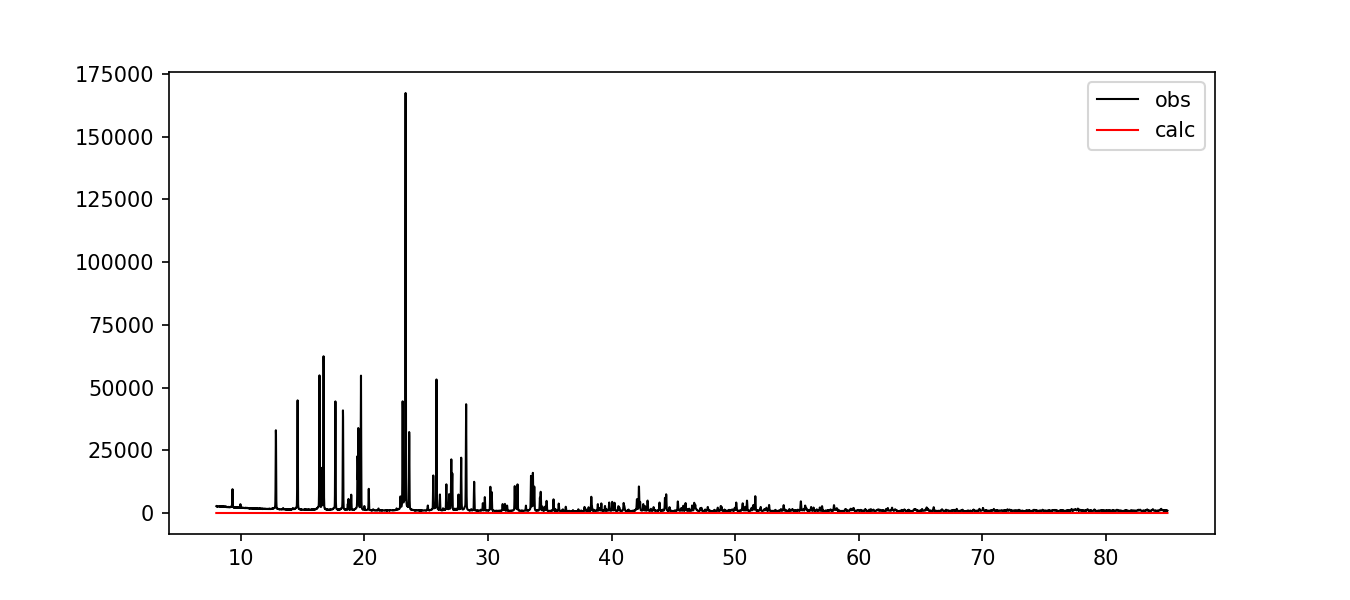

In [2]:
p = PowderPattern()
if not os.path.exists("cime.dat"):
    os.system("curl -O https://raw.githubusercontent.com/vincefn/objcryst/master/Fox/example/tutorial-cimetidine/cime.dat")
p.ImportPowderPatternFullprof("cime.dat")
p.SetWavelength(1.52904)

p.plot()

### Find peaks & index the reflections
In this case the peaks are automatically found without any parasitic phase.

And the unit cell is also indexed without any ambiguity. This uses the dichotomy in volume approach (Louër & Boultif).

... It is not always that easy !

In [3]:
# Index
pl = p.FindPeaks(1.5, -1, 1000)
if len(pl) > 20:
    pl.resize(20)  # Only keep 20 peaks
for peak in pl:
    print(peak)

ex = quick_index(pl)

print("Solutions:")
for s in ex.GetSolutions():
    print(s)

Peak dobs=0.10632+/-0.00011 iobs=2.146855e+04 (? ? ?))
Peak dobs=0.11354+/-0.00011 iobs=4.111350e+03 (? ? ?))
Peak dobs=0.14620+/-0.00011 iobs=9.429778e+04 (? ? ?))
Peak dobs=0.15277+/-0.00011 iobs=1.388049e+03 (? ? ?))
Peak dobs=0.16177+/-0.00011 iobs=1.420839e+03 (? ? ?))
Peak dobs=0.16602+/-0.00014 iobs=1.141690e+05 (? ? ?))
Peak dobs=0.18616+/-0.00011 iobs=1.609675e+05 (? ? ?))
Peak dobs=0.18839+/-0.00011 iobs=4.474511e+04 (? ? ?))
Peak dobs=0.18984+/-0.00011 iobs=1.839251e+05 (? ? ?))
Peak dobs=0.20064+/-0.00011 iobs=1.290410e+05 (? ? ?))
Peak dobs=0.20760+/-0.00011 iobs=1.182234e+05 (? ? ?))
Peak dobs=0.21186+/-0.00006 iobs=2.198665e+03 (? ? ?))
Peak dobs=0.21262+/-0.00011 iobs=8.717511e+03 (? ? ?))
Peak dobs=0.21507+/-0.00011 iobs=1.818877e+04 (? ? ?))
Peak dobs=0.22072+/-0.00008 iobs=2.098754e+04 (? ? ?))
Peak dobs=0.22153+/-0.00011 iobs=6.288388e+04 (? ? ?))
Peak dobs=0.22394+/-0.00011 iobs=1.562582e+05 (? ? ?))
Peak dobs=0.22705+/-0.00014 iobs=3.681909e+03 (? ? ?))
Peak dobs=

### Create a crystal phase using the indexed unit cell

<IPython.core.display.Javascript object>


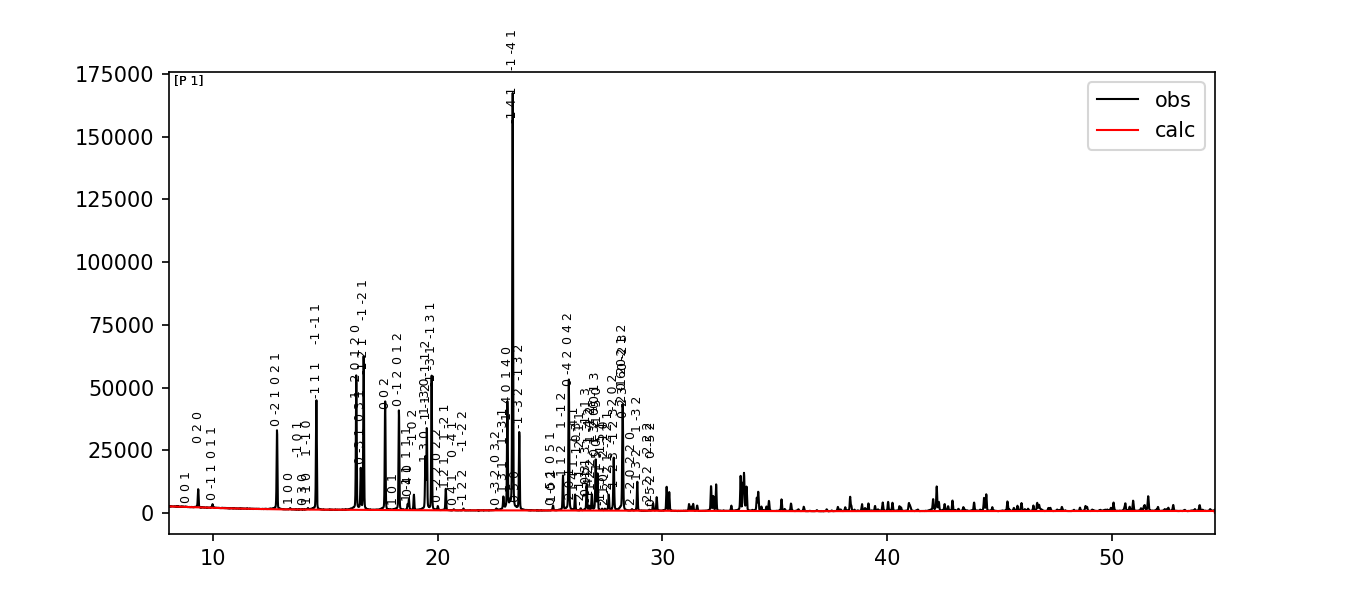

In [4]:
uc = ex.GetSolutions()[0][0].DirectUnitCell()
c = pyobjcryst.crystal.Crystal(uc[0], uc[1], uc[2], uc[3], uc[4], uc[5], "P1")
pdiff = p.AddPowderPatternDiffraction(c)

# Plot with indexing in new figure
p.plot(diff=False,fig=None,hkl=True)

### Fit the profile and background
We use a maximum sin(theta)/lambda because we don't really need high angle/high resolution data.

This will go faster and is more reliable for spacegroup indexing and structure solution.

No background, adding one automatically
Selected PowderPatternDiffraction:    with Crystal:  
Profile fitting finished.
Remember to use SetExtractionMode(False) on the PowderPatternDiffraction object
to disable profile fitting and optimise the structure.


<IPython.core.display.Javascript object>


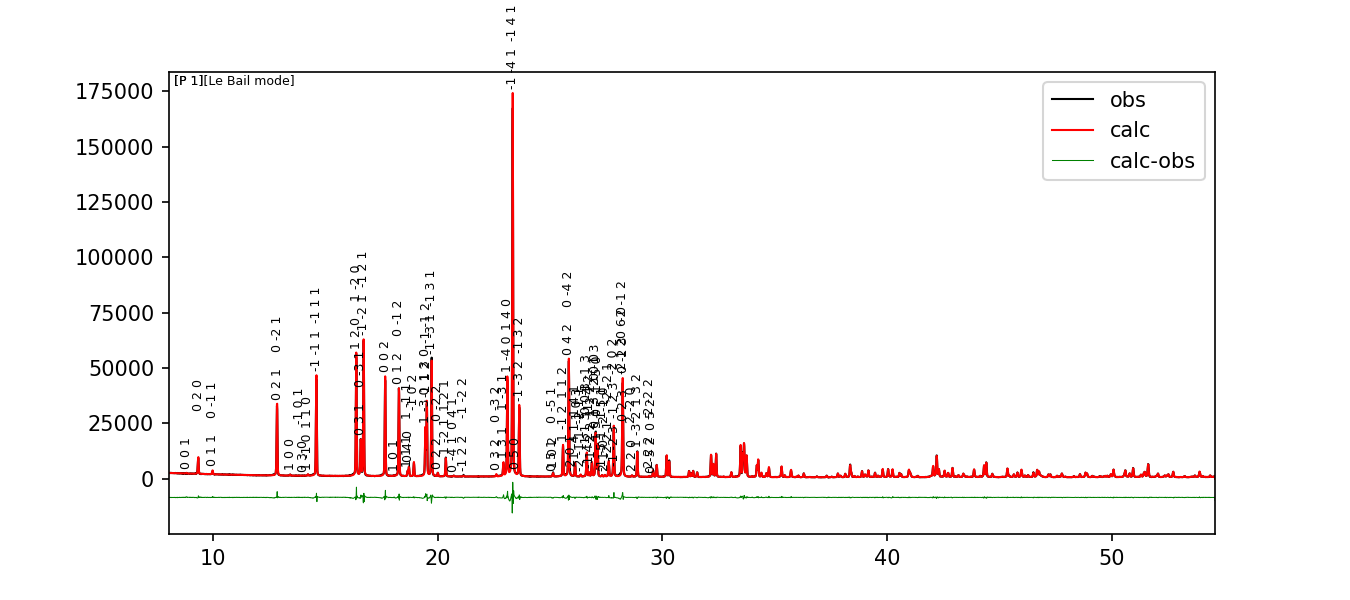

Fit result: Rw=  5.47% Chi2=  33605.40  GoF=    4.36  LLK=  6025.132


In [5]:
p.SetMaxSinThetaOvLambda(0.3)
p.quick_fit_profile(auto_background=True,plot=False, init_profile=True,verbose=True)
p.quick_fit_profile(plot=False, init_profile=False, asym=True, displ_transl=True, verbose=False)

# Plot in new figure
p.plot(diff=True, fig=None, hkl=True)
print("Fit result: Rw=%6.2f%% Chi2=%10.2f  GoF=%8.2f  LLK=%10.3f" %
      (p.rw * 100, p.chi2, p.chi2/p.GetNbPointUsed(), p.llk))

### Find the spacegroup
The SpaceGroupExplorer can be used to find the optimal spacegroup. 

What `RunAll()` does is try all spacegroups and settings which are compatible with the unit cell (in this case all monoclinic and triclinic), and perform a profile fit (Le Bail only, we don't refine profile parameters or background since these parameters should be OK).

From this several values are extracted for each spacegroup setting:
* **Rw** - the standard full-profile weighted R factor $R_{wp}$
* **GoF**: the chi2 (full profile  $\chi^2=\Sigma\frac{(obs-calc)^2}{\sigma^2}$) divided by the number of points used
* **nGoF**: this is the Goodness-of-Fit, but computed on integration intervals defined by P1 reflections, and then multipled by the number of reflections used divided by the number of reflections for the P1 spacegroup. This is more discriminating and allows to put forward spacegroups which yield a good fit with more extinctions.
* **reflections** is the number of reflections actually taken into account for this spacegroup up to the maximum sin(theta)/lambda
* **extinct446** gives the number of extinct reflections for 0<=H<=4 0<=K<=4 0<=L<=6 (which is used internally as a unique fingerprint for the extinctions)

Some C++ verbose output does not appear here but will be in the jupyter server log if you see it.

The results are sorting by ascending **nGOF**


P 1 21/c 1    nGoF=   1.4632 GoF=  13.530 Rw= 6.49 [ 92 reflections, extinct446= 17]
P 1 21 1      nGoF=   1.6245 GoF=  14.063 Rw= 6.60 [101 reflections, extinct446=  2]
P 1 21/m 1    nGoF=   1.6245 GoF=  14.063 Rw= 6.60 [101 reflections, extinct446=  2]
P 1 c 1       nGoF=   1.6386 GoF=  13.876 Rw= 6.57 [ 96 reflections, extinct446= 15]
P 1 2/c 1     nGoF=   1.6386 GoF=  13.876 Rw= 6.57 [ 96 reflections, extinct446= 15]
P 1 2 1       nGoF=   1.8120 GoF=  14.412 Rw= 6.68 [105 reflections, extinct446=  0]
P 1 m 1       nGoF=   1.8120 GoF=  14.412 Rw= 6.68 [105 reflections, extinct446=  0]
P 1 2/m 1     nGoF=   1.8120 GoF=  14.412 Rw= 6.68 [105 reflections, extinct446=  0]
P -1          nGoF=   3.1167 GoF=  14.671 Rw= 6.73 [186 reflections, extinct446=  0]
P 1           nGoF=   3.1167 GoF=  14.671 Rw= 6.73 [186 reflections, extinct446=  0]
P 1 21/n 1    nGoF=   5.3921 GoF=  26.667 Rw= 9.11 [ 92 reflections, extinct446= 19]
P 1 n 1       nGoF=   5.7411 GoF=  27.031 Rw= 9.17 [ 96 reflectio

<IPython.core.display.Javascript object>


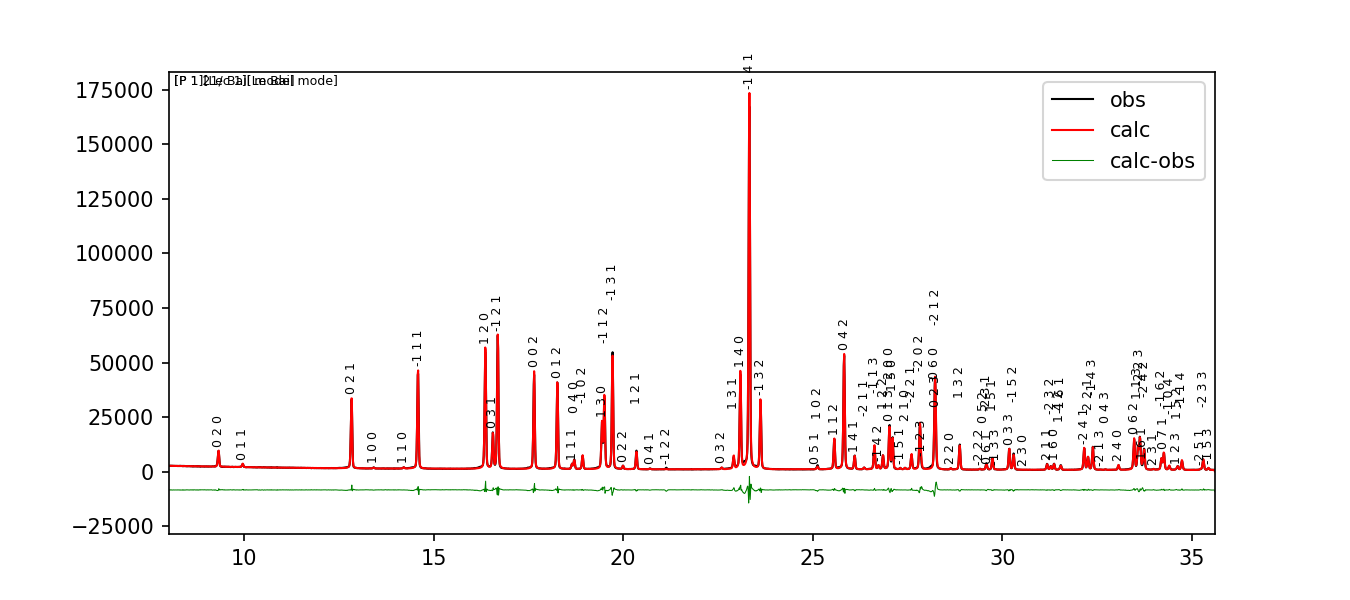

In [6]:
p.SetMaxSinThetaOvLambda(0.2)  # Important for stability of profile fit. And faster !
spgex = SpaceGroupExplorer(pdiff)

# NB:verbose C++ output does not appear in a notebook
spgex.RunAll(keep_best=True, update_display=False, fitprofile_p1=False)

for sol in spgex.GetScores():
    #if sol.nGoF > 4 * spgex.GetScores()[0].nGoF:
    if sol.GoF <= 2 * spgex.GetScores()[0].GoF:
        print(sol)

print("Chosen spacegroup (smallest nGoF): ", c.GetSpaceGroup())

# Updated plot with optimal spacegroup
p.plot(diff=True, fig=None, hkl=True, reset=True)

### Add Cimetidine molecule to the crystal structure
This is imported from a Fenske-Hall z-matrix, downloaded as needed.

We can also look at options, and disable the Dynamical Occupancy Correction, because we don't expect the molecule atoms to be overlapping with each other.

In [7]:
if not os.path.exists("cime.fhz"):
    os.system("curl -O https://raw.githubusercontent.com/vincefn/objcryst/master/Fox/example/tutorial-cimetidine/cime.fhz")

# This will automatically add the Molecule to the Crystal object
m = ImportFenskeHallZMatrix(c,"cime.fhz")
print("Crystal Formula:", c.GetFormula())
print()

# List the options to see which are available
for i in range(c.GetNbOption()):
    o = c.GetOption(i)
    print("Option #%d: %s = %s"% (i, o.GetName(), o.GetChoiceName(o.GetChoice())))
    for j in range (o.GetNbChoice()):
        print("   Choice %d: %s" %(j, o.GetChoiceName(j)))


c.GetOption(1).SetChoice(0)

Crystal Formula: C9 N6 S1

Option #0: Constrain Lattice to SpaceGroup Symmetry = Yes (Default)
   Choice 0: Yes (Default)
   Choice 1: No (Allow Crystallographic Pseudo-Symmetry)
Option #1: Use Dynamical Occupancy Correction = Yes
   Choice 0: No
   Choice 1: Yes
Option #2: Display Enantiomer = No
   Choice 0: No
   Choice 1: Yes


### Create a MonteCarlo object and add objects (crystal, powder pattern) for optimisation

In [8]:
mc = MonteCarlo()
mc.AddRefinableObj(c)
mc.AddRefinableObj(p)

### Disable profile fitting before Monte-Carlo
..or else the crystal structure will not be optimised

Note that the following display will be live-updated during the optimisation done below (the last plot is alwasy updated).

<IPython.core.display.Javascript object>


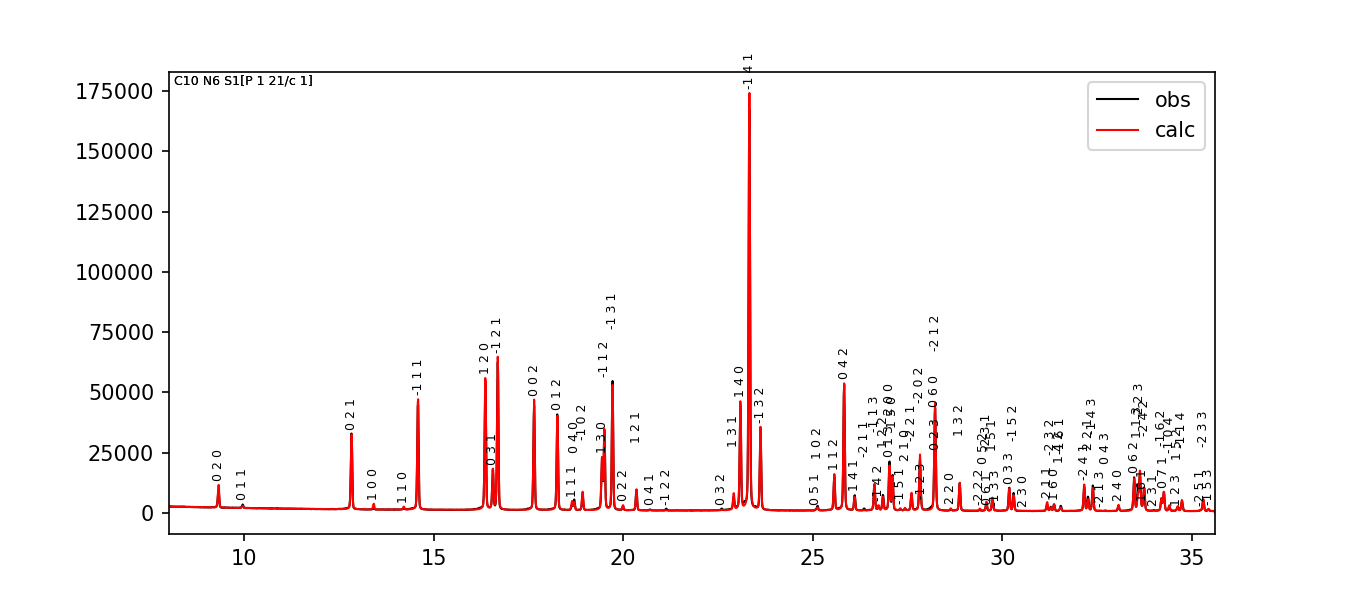

In [9]:
pdiff.SetExtractionMode(False)
p.FitScaleFactorForRw() # for a better initial display
p.plot(fig=None,diff=False,hkl=True)

### Display the 3D crystal structure
*Note: this requires installing `ipywidgets` and `py3Dmol` (as of 2021/05 the conda-forge version is obsolete, so just install using pip). Otherwise You will just get a warning message*

This will be updated live during the optimisation, and also when using `RestoreParamSet()` to restore some specific solutions (and generally everytime the underlying Crystal's `UpdateDisplay()` function is called). Just scroll back to see what is being done in the widget.

The `display()` is only really necessary to make sure the widget appears in the notebook. In fact if `c.widget_3d()` is the *last* command in the notebook cell, the display is done automatically. See the ipywidgets documentation if you want to understand this in more details.

Note that bonds may disappear during optimisation, because they are automatically assigned by the javascript viewer, which is quite strict about allowed distances. In the final solution some bonds in the middle of the chain are often missing, though you can see the atoms are reasonably close. But rest assured that any bond defined in the object still exists as defined in pyobjcryst !

In [10]:
display(c.widget_3d())

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Box(children=(VBox(children=(HBox(children=(VBox(children=(FloatRangeSlider(value=(0.0, 1.0), description='Xra…

### Run multiple optimisations
We also enable the automatic least squares every 150k trials, which allows a better convergence

We perform 3 runs, each of 500k trials using parallel tempering, with default parameters (which should be adequate for all problems). Normally for this structure it would be better to use 1 or 2 millions trials to be almost sure that the correct solution will be found during every run.

Each run starts from a randomised configuration.

In [11]:
mc.GetOption("Automatic Least Squares Refinement").SetChoice(2)
print("LSQ option: ", mc.GetOption("Automatic Least Squares Refinement").GetChoiceName(2))

# The above plot should be updated with new best solution during each run
mc.MultiRunOptimize(nb_run=5, nb_step=1e6)
print("Final LLK: %.2f" % mc.GetLogLikelihood())

LSQ option:  Every 150000 trials, and at the end of each run
Run  0  Trial    39900  LLK=  1387253.14


Run  0  Trial    79500  LLK=  1195337.02


Run  0  Trial   119400  LLK=  1184896.59


Run  0  Trial   150000  LLK=   249704.72


Run  0  Trial   300000  LLK=    21015.64


Run  0  Trial   450000  LLK=    21006.28


Run  0  Trial   600000  LLK=    20810.87


Run  0  Trial   750000  LLK=    20807.00


Run  0  Trial  1000200  LLK=    20807.00


Run  1  Trial    39300  LLK=  1601665.50


Run  1  Trial    78900  LLK=  1433654.53


Run  1  Trial   118200  LLK=  1195318.76


Run  1  Trial   150000  LLK=   220388.65


Run  1  Trial   300000  LLK=   189391.57


Run  1  Trial   340200  LLK=   189391.57


Run  1  Trial   450000  LLK=    52597.72


Run  1  Trial   600000  LLK=    20996.09


Run  1  Trial   970200  LLK=    20996.09


Run  1  Trial  1000200  LLK=    20996.09


Run  2  Trial    38700  LLK=  1431559.70


Run  2  Trial    78900  LLK=  1360774.53


Run  2  Trial   119400  LLK=  1190596.49


Run  2  Trial   150000  LLK=    53641.13


Run  2  Trial   300000  LLK=    20811.19


Run  2  Trial   653100  LLK=    20811.19


Run  2  Trial  1000200  LLK=    20811.19


Run  3  Trial    39900  LLK=  1552005.36


Run  3  Trial    79500  LLK=  1238048.35


Run  3  Trial   118800  LLK=  1206495.49


Run  3  Trial   150000  LLK=   180097.13


Run  3  Trial   300000  LLK=    20925.20


Run  3  Trial   450000  LLK=    20825.97


Run  3  Trial   813000  LLK=    20825.97


Run  3  Trial   900000  LLK=    20815.81


Run  3  Trial  1000200  LLK=    20815.81


Run  4  Trial    39300  LLK=  1207843.89


Run  4  Trial    79200  LLK=  1161861.86


Run  4  Trial   118800  LLK=  1160329.57


Run  4  Trial   150000  LLK=    50086.29


Run  4  Trial   300000  LLK=    50057.90


Run  4  Trial   450000  LLK=    20962.88


Run  4  Trial   750000  LLK=    20894.83


Run  4  Trial  1000200  LLK=    20894.83


MonteCarlo: current LLK=    18438.84


Final LLK: 18438.84


### List solutions
All solutions are stored in a "Parameter Set" which can be restored (assuming that the objects - crystal structure and powder pattern are not altered e.g. by changing the list of atoms, the profile, or the fixed parameters etc...).

This will only record changes of parameters such as atom coordinates, but will not record other changes such as a different spacegroup, or a change of the Scatterers (number of atoms or molecules) inside a Crystal. It can only be used to browse results obtained at the end of `MultiRunOptimize()`.

At the end of the optimisation the best solution is automatically restored.

In [12]:
for i in range(mc.GetNbParamSet()):
    idx = mc.GetParamSetIndex(i)
    cost = mc.GetParamSetCost(i)
    name = mc.GetFullRefinableObj().GetParamSetName(idx)
    print("%3d: LLK=%10.2f, name=%s"%(idx, cost, name))

  0: LLK=  20806.00, name=Best Configuration
  1: LLK=  20806.00, name=Run #5
  2: LLK=  20996.00, name=Run #4
  3: LLK=  20811.00, name=Run #3
  4: LLK=  20815.00, name=Run #2
  5: LLK=  20894.00, name=Run #1


### Restore a chosen solution (set of parameters)
Restoring a solution will also update the 3D crystal view above.

<IPython.core.display.Javascript object>


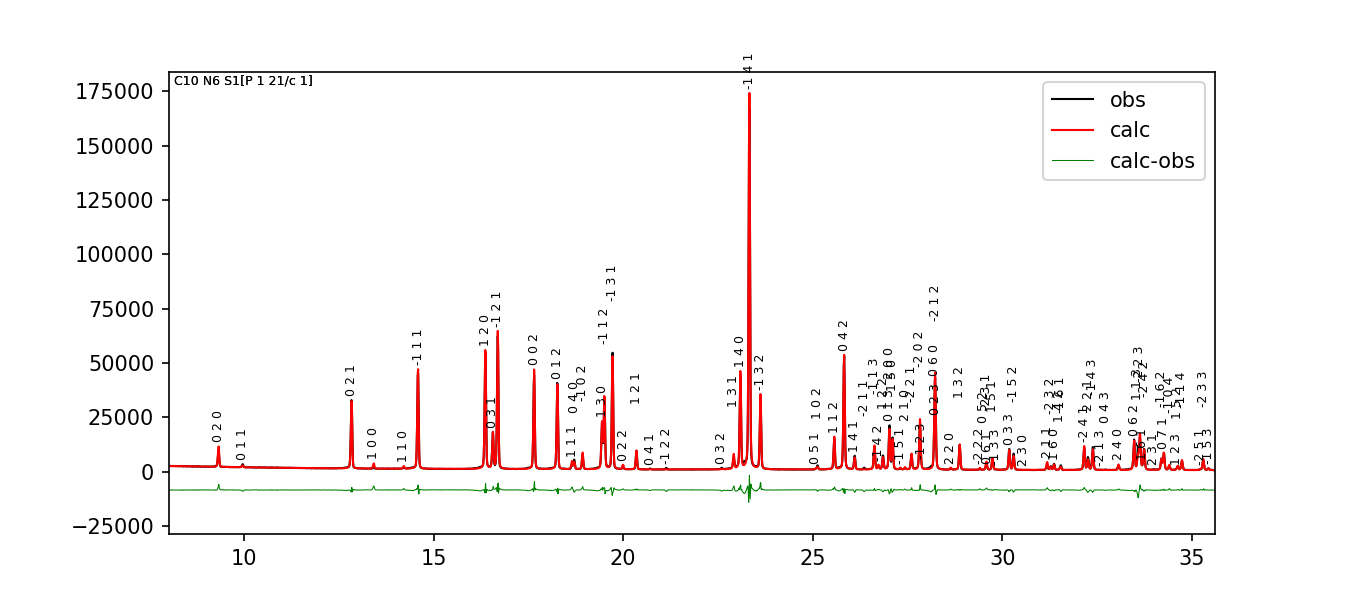

MonteCarlo: current LLK=    18438.84


In [15]:
p.plot(fig=None, diff=True)
mc.RestoreParamSet(0, update_display=True)

### Save results to CIF and Fox (.xmlgz) formats

In [14]:
# Save result so it can be opened by Fox
xml_cryst_file_save_global('result.xmlgz')
# Also export to the CIF format
c.CIFOutput("result.cif")